# Combining PennyLane with Amazon Braket

In [1]:
# Use Braket SDK Cost Tracking to estimate the cost to run this example
from braket.tracking import Tracker
t = Tracker().start()

<div class="alert alert-block alert-info">
<b>PennyLane とは?</b> <a href="https://pennylane.ai/install.html">PennyLane</a> は、量子コンピュータの微分可能プログラミングのための Python ライブラリです。ニューラルネットワークと同様に量子コンピュータを訓練することができます。
</div>

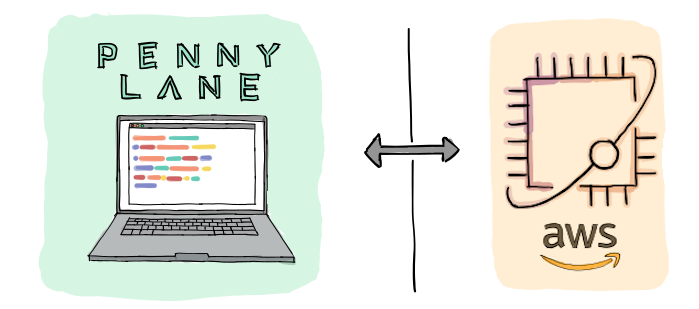

PennyLane は Amazon Braket と統合され、量子機械学習と最適化のための追加機能を提供します。この入門チュートリアルでは、Amazon Braket シミュレータと PennyLane の自動微分機能を使用して量子回路を訓練する方法について説明します。

## セットアップ

PennyLane はすでに Braket ノートブックインスタンスにインストールされています。ローカルマシンでは、PennyLane を [こちら](https://pennylane.ai/install.html) の指示に従ってインストールできます。その後、以下のようにインポートします: 

In [2]:
import pennylane as qml
from pennylane import numpy as np

Braket を PennyLane のバックエンドとして使用するには、PennyLane デバイスを作成する必要があります。ここでは、まずローカル環境 (このノートブックをホストするサーバー) 上で動作するローカルの Braket シミュレーター `"braket.local.qubit"` を使用するデバイスを作成します。

In [3]:
wires = 2  # Number of qubits

dev = qml.device("braket.local.qubit", wires=wires)

以下では、シミュレーションを AWS クラウド上でスケールアウトさせる方法も示します。

## 回路の定義

ここでは、パラメータ付けられた2つの回転ゲートと CNOT ゲートを備えた単純な2量子ビット回路を定義します。

In [4]:
@qml.qnode(dev)
def circuit(params):
    qml.RX(params[0], wires=0)
    qml.RY(params[1], wires=1)
    qml.CNOT(wires=[0, 1])
    return qml.expval(qml.PauliZ(1))

``qml.qnode (dev) ``デコレータは、回路をローカルの Braket デバイスにバインドします。つまり、この ``circuit () `` が呼ばれるたびに、上記の関数で定義した量子計算が Braket で実行されるようになっています。

<div class="alert alert-block alert-info">
<b>注:</b> PennyLane は、<a href="https://pennylane.readthedocs.io/en/stable/introduction/interfaces.html"> PyTorch および TensorFlow インターフェイスによる自動微分もサポートしています</a>。インターフェイスの選択は、以下を使用して指定できます: 
<code>@qml.qnode(dev, interface="&lt;interface&gt;")</code>
</div>

## 回路の評価と勾配へのアクセス

制御可能なパラメータにいくつかの値を設定してみましょう。

In [5]:
params = np.array([0.1, 0.2])

この回路は、以下のようにしてこれらのパラメータで評価できます。

In [6]:
print("Expectation value of circuit:", circuit(params))

Expectation value of circuit: 0.9751703272018161


In [7]:
print("Drawing of circuit:\n")
print(qml.draw(circuit)(params))

Drawing of circuit:

0: ──RX(0.10)─╭C─┤     
1: ──RY(0.20)─╰X─┤  <Z>


機械学習と最適化の重要な要素は、パラメーターに関するモデルの勾配にアクセスすることです。この機能は PennyLane に組み込まれています: 

In [8]:
dcircuit = qml.grad(circuit)

ここで、``dcircuit`` は回路の勾配、すなわち制御可能なパラメータに対する偏導関数を評価する呼び出し可能な関数です。

In [9]:
dcircuit(params)

array([-0.0978434 , -0.19767681])

## 回路の訓練

ここで、回路のパラメータを更新して回路の出力を最小化したいとします。これは、勾配ベースの最適化を使用して実行できます。

まず、オプティマイザを指定します。

In [10]:
opt = qml.GradientDescentOptimizer(stepsize=0.2)

次のステップで、選択した反復回数だけオプティマイザを実行します。

In [11]:
iterations = 50

costs = []

for i in range(iterations):
    params, cost = opt.step_and_cost(circuit, params)
    costs.append(cost)

# Visualize results
import matplotlib.pyplot as plt    
costs.append(circuit(params))
plt.plot(costs)
plt.xlabel("Iterations")
plt.ylabel("Cost")

print("Minimized circuit output:", circuit(params))
print("Optimized parameters:", params)

Minimized circuit output: -0.9999996577749632
Optimized parameters: [4.19618503e-04 3.14087965e+00]


<div class="alert alert-block alert-info">
<b>注: </b>ここで説明する回路は非常に単純で、手作業で簡単に最適化できます。しかし、PennyLane の自動微分機能の必要性は、ゲートが増え、異なる種類の測定を行うなど、問題をより複雑にするにつれて明らかになります。後のデモでは、Braket を使用して勾配評価を並列化し、PennyLane で量子回路の訓練を高速化する方法についても説明します。
</div>

## Braket のマネージドシミュレータ SV1 で回路の実行

ここまでは、ローカルの Braket シミュレータを使用してきました。これは素早いプロトタイピングには適していますが、量子ビット数の多い大きな回路には適さず、そのままだと量子ハードウェアへの接続もできません。

Amazon Braket は、完全マネージド型の高性能シミュレータと、さまざまな [ハードウェアプロバイダ](https://aws.amazon.com/braket/hardware-providers/) による量子処理装置 (Quantum Processing Unit; QPU) へのアクセスも提供しています。これらのデバイスは、PennyLane を介してたった一行のコード行を変更することでアクセスでき、量子ハードウェアと高性能シミュレータでの機械学習と最適化の可能性を解き放ちます。

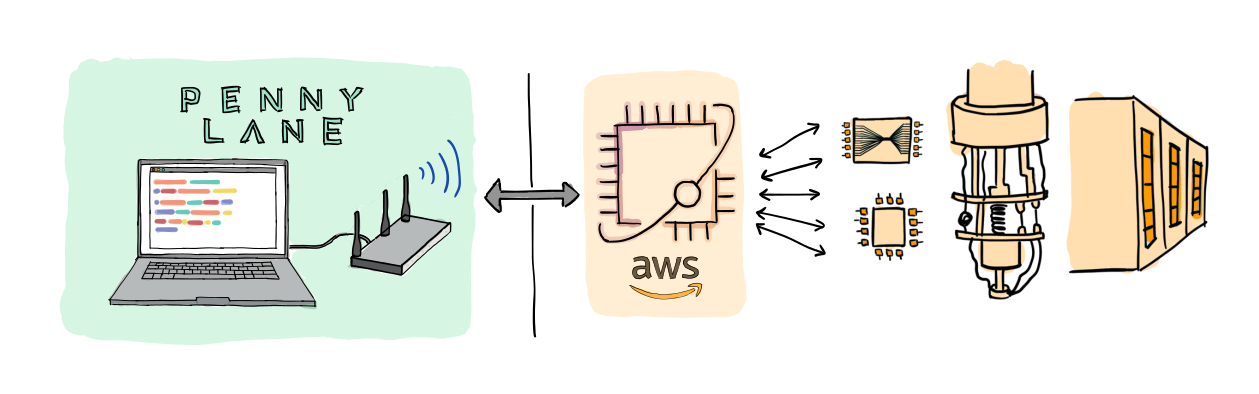

各リモート Braket デバイスは、その [ARN](https://docs.aws.amazon.com/general/latest/gr/aws-arns-and-namespaces.html) で選択できます。Braket でサポートされるデバイス一覧は [このページ](https://docs.aws.amazon.com/braket/latest/developerguide/braket-devices.html) で確認できます。ここでは、マネージド SV1 シミュレータを選択します。

<div class="alert alert-block alert-warning">
<b>注:</b> QPU でハイブリッドアルゴリズムを実行すると時間がかかり、AWS アカウントに高額の<a href="https://aws.amazon.com/braket/pricing/">利用料</a>が請求される可能性があります。
</div>

In [12]:
device_arn = "arn:aws:braket:::device/quantum-simulator/amazon/sv1"

PennyLane では、すべてのリモート Braket デバイスは ``braket.aws.qubit`` という名前の単一の PennyLane デバイスを介してアクセスされます。

In [13]:
dev = qml.device('braket.aws.qubit', device_arn=device_arn, wires=2)

次の [チュートリアル](./1_parallelized_optimization_of_quantum_Circuits.ipynb) では、リモートデバイスを使用して複数の回路を並列に実行する方法を示します。[QAOA チュートリアル](./2_graph_optimization_with_qaoa.ipynb) では、SV1を使用して20頂点グラフの最適化問題を解くなど、グラフの最適化についてさらに深く掘り下げています。

SV1 で回路を実行し、勾配を計算してみましょう: 

In [14]:
@qml.qnode(dev)
def circuit(params):
    qml.RX(params[0], wires=0)
    qml.RY(params[1], wires=1)
    qml.CNOT(wires=[0, 1])
    return qml.expval(qml.PauliZ(1))


dcircuit = qml.grad(circuit)

print("Result of circuit run on SV1:", circuit(params))
print("Result of gradient calculation on SV1:", dcircuit(params))

Result of circuit run on SV1: -0.9999996577749632
Result of gradient calculation on SV1: [ 0.00041962 -0.000713  ]


<div class="alert alert-block alert-info">
<b>次のステップは？</b> このディレクトリにある他のチュートリアルを試して、グラフの最適化から量子化学計算まで、さまざまな問題を解くために Braket と PennyLane を組み合わせる方法について理解しましょう。
</div>

In [15]:
print("Task Summary")
print(t.quantum_tasks_statistics())
print('Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).')
print(f"Estimated cost to run this example: {t.qpu_tasks_cost() + t.simulator_tasks_cost():.3f} USD")

Task Summary
{'arn:aws:braket:::device/quantum-simulator/amazon/sv1': {'shots': 0, 'tasks': {'COMPLETED': 6}, 'execution_duration': datetime.timedelta(microseconds=82000), 'billed_execution_duration': datetime.timedelta(seconds=18)}}
Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).
Estimated cost to run this example: 0.022 USD
